# Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LogisticGAM, LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from scipy import sparse
import models


In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30


In [4]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [9]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [10]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [11]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

# Example of feature engineering. Created a column (median price of zipcode the home is in). We can try to see how this feature help in predicting home prices

In [12]:
#add median home value to each row for corresponding zip_code. Also added a log2value for zip_median
zip1 = df.zip_code
list1 = list(zip1)
(df[df.zip_code == list1[3]]).assessed_value.median()

def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

list3 = median_v(df, list1)
list3 = pd.DataFrame(list3, columns=['zip_median'])
df = pd.concat([df, list3], axis=1)
df['log2_zip_median'] = np.log2(df['zip_median'])

In [13]:
from math import radians, sin, cos, sqrt, asin
 
 
def haversine(lat1, lon1):
    lat2 = 34.724
    lon2 = -117.882
    R = 6372.8  # Earth radius in kilometers
 
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
 
    a = sin(dLat / 2)**2 + cos(lat1) * cos(lat2) * sin(dLon / 2)**2
    c = 2 * asin(sqrt(a))
 
    return R * c

In [14]:
df['harversine_distance'] = [haversine(x, y) for x, y in zip(df.latitude/1000000, df.longitude/1000000)]

In [15]:
df

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median,harversine_distance
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431,21.546420
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632,88.899173
2,3.0,4.0,2541.0,6059,4975,0,96958,2003,33694636.0,-117912245.0,...,2017-06-01,0.011153,Orange,11.311181,12.280481,19.747891,-3,518484.0,18.983940,114.526186
3,2.0,3.0,1650.0,6037,7300,0,96037,1949,33985377.0,-118361620.0,...,2017-06-01,0.012497,Los Angles,10.688250,12.833681,19.227879,51,653668.5,19.318200,93.213971
4,1.0,2.0,693.0,6037,2908,0,96023,1921,34112946.0,-118208106.0,...,2017-06-29,0.011915,Los Angles,9.436712,11.505812,18.065064,79,345184.0,18.397006,74.260088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14868,3.0,5.0,2526.0,6059,7800,1,97018,1994,33753643.0,-117766503.0,...,2017-06-30,0.012462,Orange,11.302639,12.929258,18.807830,6,876094.5,19.740727,108.450468
14869,3.0,5.0,2735.0,6059,7100,1,97067,1963,33783173.0,-117817799.0,...,2017-06-30,0.012704,Orange,11.417325,12.793603,16.816121,37,496144.0,18.920399,104.811059
14870,2.0,3.0,1536.0,6037,8818,1,96523,1955,34058178.0,-117948180.0,...,2017-06-30,0.011847,Los Angles,10.584963,13.106236,18.180575,45,196360.0,17.583142,74.305633
14871,3.0,5.0,2655.0,6059,6000,0,97065,1994,33836898.0,-117801369.0,...,2017-06-30,0.010798,Orange,11.374496,12.550747,19.510677,6,479697.5,18.871765,98.946981


In [16]:
# save data in a .csv file
df.to_csv('zillow_cleaned1.csv')

In [17]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [18]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'harversine_distance', 'assessed_value']]

In [19]:
#df.groupby(['zip_code']).agg(['mean', 'count'])

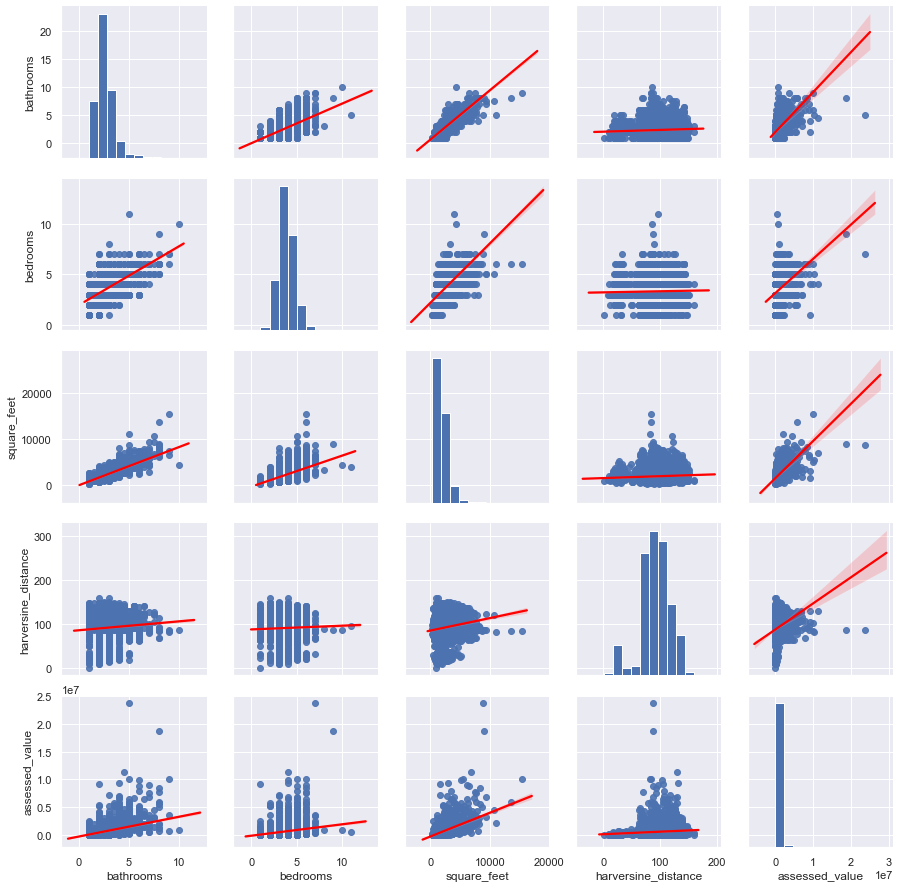

In [20]:
explore.plot_variable_pairs(train_plot)

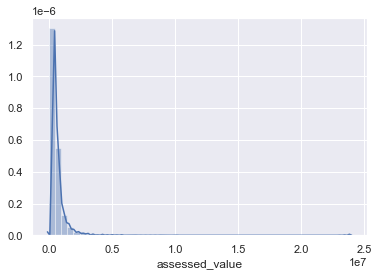

In [21]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [22]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,harversine_distance,assessed_value
bathrooms,1.000000,0.641827,0.854944,0.079816,0.505229
bedrooms,0.641827,1.000000,0.628387,0.030077,0.263875
square_feet,0.854944,0.628387,1.000000,0.108428,0.588502
harversine_distance,0.079816,0.030077,0.108428,1.000000,0.164899
assessed_value,0.505229,0.263875,0.588502,0.164899,1.000000


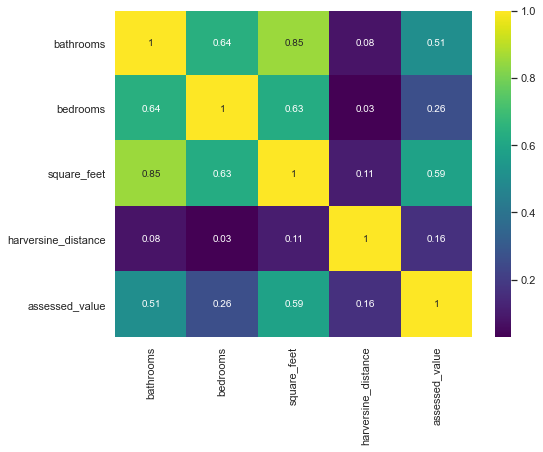

In [23]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

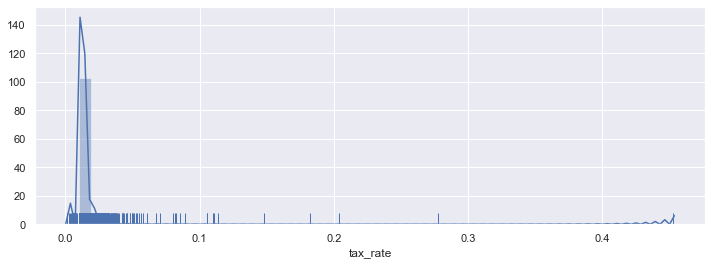

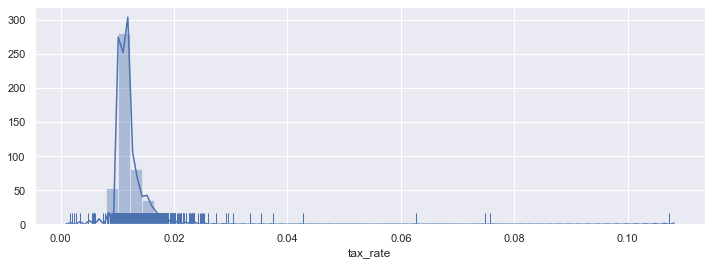

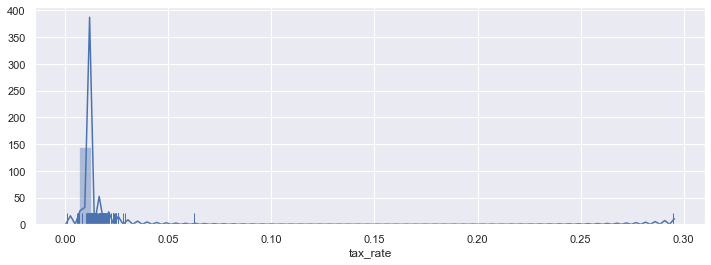

In [24]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [247]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['log2sf', 'log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'log2_zip_median']]
y_test = test[['log2value']]

In [248]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.log2value
})
predictions.head(2)

,actual
11938,18.035
790,16.548


In [249]:
#predictions['median_bl'] =  train['assessed_value'].median()
#predictions['mean_bl'] =  train['assessed_value'].mean()

In [250]:
predictions.head(2)

,actual
11938,18.035
790,16.548


In [252]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ log2sf + log2_zip_median',  data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [253]:
predictions['actual1'] =  2**predictions['actual']
predictions['predicted1'] =  2**predictions['ols']

In [254]:
predictions.head(2)

,actual,ols,actual1,predicted1
11938,18.035,18.076,268557.000,276365.741
790,16.548,18.702,95849.000,426321.757


In [255]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual1, col))

actual       389591.428
ols          389591.628
actual1           0.000
predicted1   153470.411
dtype: float64

In [256]:
predictions.apply(lambda col: r2_score(predictions.actual1, col))

actual       -0.573
ols          -0.573
actual1       1.000
predicted1    0.424
dtype: float64

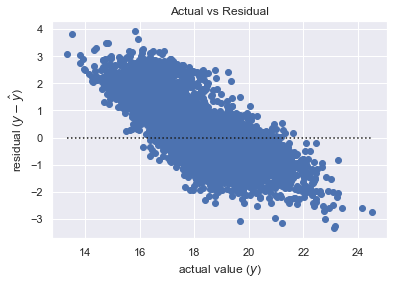

In [257]:
#Lets look at residuals
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)



# Looks like there is a clear trend. The model seems to be doing well at lower home values, but diverges significantly at higher price levels. 

In [258]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     4082.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:29:04   Log-Likelihood:                -15052.
No. Observations:               10411   AIC:                         3.011e+04
Df Residuals:                   10408   BIC:                         3.013e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.1794      0.244    -13.009      0.000      -3.658      -2.700
log2sf              0.7889      0.018     44.491      0.000       0.754       0.824
log2_zip_median     0.7015      0.014     50.320      0.000       0.674       0.729
==============================================================================
Omnibus:                      941.276   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1215.806
Skew:                          -0.830   Prob(JB):                    9.80e-265
Kurtosis:                       3.217   Cond. No.                         525.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

-------------------------------

# Lets apply this model on test data and see how it performs

In [259]:
y_test['y_ols'] = ols_model.predict(X_test)

In [261]:
y_test

,log2value,y_ols
9116,20.367,19.889
2397,19.605,19.556
2849,15.956,17.161
14308,19.246,19.166
9780,18.469,18.508
...,...,...
13270,20.049,19.226
14751,16.291,18.203
2874,18.159,18.672
7178,18.936,18.443


In [264]:
y_test['actual1'] =  2**y_test['log2value']
y_test['predicted1'] =  2**y_test['y_ols']

In [266]:
y_test.apply(lambda col: median_absolute_error(y_test.actual1, col))

log2value    371192.998
y_ols        371192.695
actual1           0.000
predicted1   149755.201
dtype: float64

# The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

-----------------------------------------------------

(8.0, 26.0)

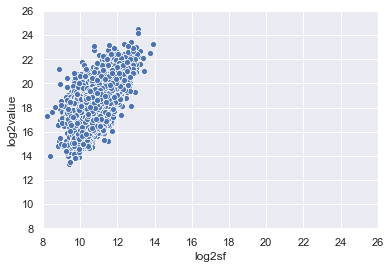

In [37]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2sf', y = 'log2value', data=train, ax = ax)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

(8.0, 26.0)

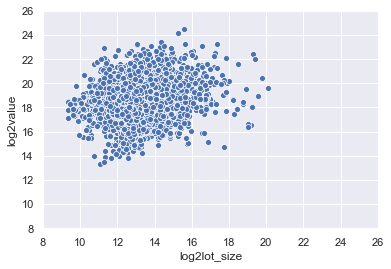

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2lot_size', y = 'log2value', data=train)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

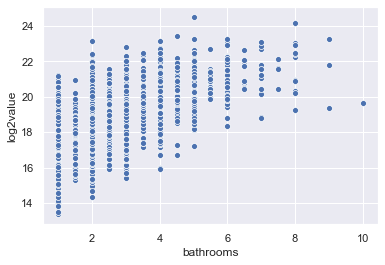

In [39]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

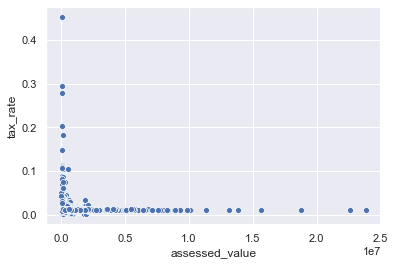

In [40]:
sns.scatterplot(x='assessed_value', y = 'tax_rate', data=df)

# Tax rate seems to be higher for lower valued properties!!

------------------------------------

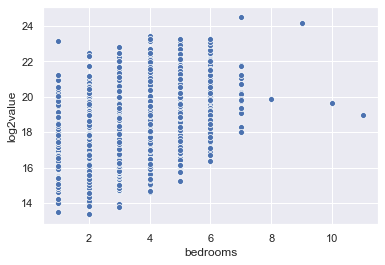

In [41]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# May be we should try to fit a polynomial function to predict price using log2sf

In [42]:
X_train = train[[ 'log2sf', 'log2_zip_median', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'bathrooms']]
y_test = test[['log2value']]

In [43]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3']

In [44]:
X_poly[1]

array([1.00000000e+00, 1.07355560e+01, 1.91173463e+01, 2.00000000e+00,
       1.15252163e+02, 2.05235343e+02, 2.14711120e+01, 3.65472931e+02,
       3.82346927e+01, 4.00000000e+00, 1.23729605e+03, 2.20331552e+03,
       2.30504326e+02, 3.92355512e+03, 4.10470685e+02, 4.29422241e+01,
       6.98687259e+03, 7.30945861e+02, 7.64693853e+01, 8.00000000e+00])

In [45]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [46]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['assessed_value'].median()

In [47]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.035,18.092,268557.000,279484.119
790,16.548,18.530,95849.000,378609.481


In [48]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            389591.428
log_predicted_poly   389591.769
actual                    0.000
poly_predicted       152438.326
dtype: float64

In [49]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.573
log_predicted_poly   -0.573
actual                1.000
poly_predicted        0.501
dtype: float64

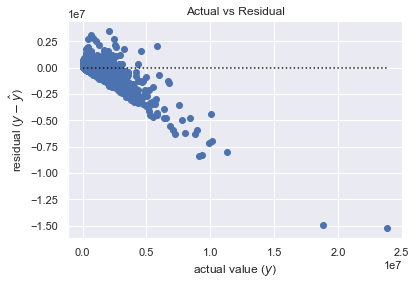

In [50]:
evaluate.plot_residuals(y_train.actual, y_train.poly_predicted, y_train)

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 171,567
# R2 value: 0.295

# Generalized Additive Model (GAM)

In [122]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [166]:
X_train = train[['bathrooms', 'log2sf']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf']]
y_test = test[['log2value']]

In [167]:
#scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [168]:
X_train= X_train.to_numpy()
y_train = y_train.to_numpy()

In [169]:
y_train

array([[18.0348688 ],
       [16.54847576],
       [18.30836125],
       ...,
       [19.3442699 ],
       [18.98462985],
       [18.06662005]])

In [173]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1))

In [174]:
gam.gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

In [175]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.4673
Link Function:                     IdentityLink Log Likelihood:                                -16110.3687
Number of Samples:                        10411 AIC:                                             32273.672
                                                AICc:                                           32273.8121
                                                GCV:                                                1.2688
                                                Scale:                                              1.2632
                                                Pseudo R-Squared:                                   0.3308
Feature Function                  Lam

In [176]:
y_pred = gam.predict(X_train)

In [177]:
y_pred

array([18.66222344, 18.17669141, 18.39514978, ..., 17.98641168,
       19.08768571, 17.99815235])

In [178]:
y_pred = pd.DataFrame(y_pred)

In [179]:
y_pred['actual'] =y_train

In [180]:
y_pred.head(2)

,0,actual
0,18.662,18.035
1,18.177,16.548


In [181]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [182]:
y_pred['residual'] = y_pred.actual1-y_pred['predicted1']

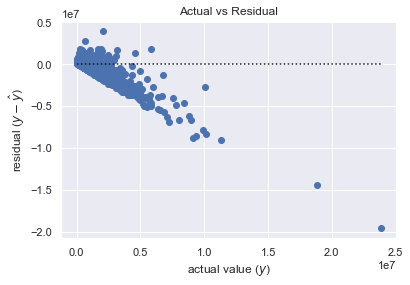

In [183]:
evaluate.plot_residuals(y_pred.actual1, y_pred['predicted1'], y_pred)

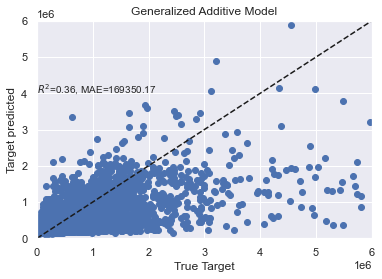

In [184]:
f, (ax1) = plt.subplots(1, 1)


ax1.scatter(y_pred['actual1'], y_pred['predicted1'])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_pred['actual1'], y_pred['predicted1']), median_absolute_error(y_pred['actual1'], y_pred['predicted1'])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

#f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [185]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual1, col))

0            389591.956
actual       389591.428
actual1           0.000
predicted1   169350.166
residual     302920.448
dtype: float64

In [186]:
y_pred.apply(lambda col: r2_score(y_pred.actual1, col))

0            -0.573
actual       -0.573
actual1       1.000
predicted1    0.357
residual      0.378
dtype: float64

# GAM Summary with test data
# Median Absolute Error: 153,409
# R2 value: 0.617

In [ ]:

# i=2
# XX = gam.generate_X_grid(term=i)
# XX[:, i]
# #ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))

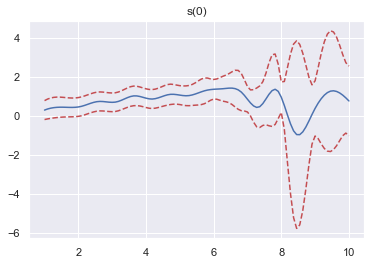

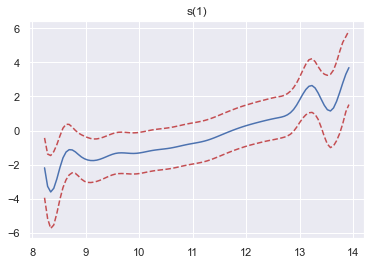

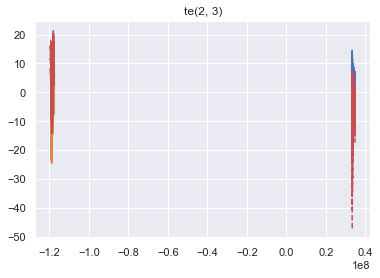

In [163]:
# Lets plot partial dependence plots for each 
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

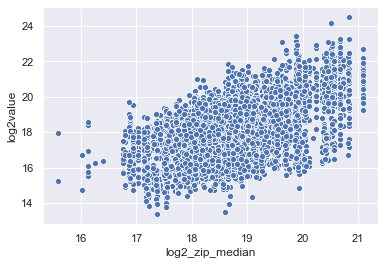

In [164]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

# Lets try a polynomial linear model with X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude']]

In [307]:
X_train = train[['bathrooms', 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median']]
y_test = test[['log2value']]
X_train1 = df[['bathrooms', 'log2sf','log2_zip_median']]
y_train1 = df[['log2value']]

In [302]:
# X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
# y_train = train[['assessed_value']]
# X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
# y_test = test[['assessed_value']]

In [317]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3']

In [320]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly.head(2)

,1,bathrooms,log2sf,log2_zip_median,bathrooms^2,bathrooms log2sf,bathrooms log2_zip_median,log2sf^2,log2sf log2_zip_median,log2_zip_median^2,bathrooms^3,bathrooms^2 log2sf,bathrooms^2 log2_zip_median,bathrooms log2sf^2,bathrooms log2sf log2_zip_median,bathrooms log2_zip_median^2,log2sf^3,log2sf^2 log2_zip_median,log2sf log2_zip_median^2,log2_zip_median^3
0,1.000,3.000,11.057,17.865,9.000,33.170,53.595,122.249,197.525,319.154,27.000,99.510,160.784,366.748,592.576,957.461,1351.666,2183.967,3528.765,5701.637
1,1.000,2.000,10.736,19.117,4.000,21.471,38.235,115.252,205.235,365.473,8.000,42.942,76.469,230.504,410.471,730.946,1237.296,2203.316,3923.555,6986.873


In [322]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [323]:
y_train.head()

,log2value,log_predicted_poly
11938,18.035,18.092
790,16.548,18.530
3846,18.308,18.657
14846,18.931,18.901
1469,18.982,18.063


In [324]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['log2value'].median()

In [325]:
y_train.head(2)
#y_train.to_csv('poly2_non_spatial.csv')

In [326]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            389591.428
log_predicted_poly   389591.769
actual                    0.000
poly_predicted       152438.326
dtype: float64

In [327]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.573
log_predicted_poly   -0.573
actual                1.000
poly_predicted        0.501
dtype: float64

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 152,438
# R2 value: 0.501

-----------------------------------------------------

# Lets try Ridge Regressions with cross-validation

In [ ]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [110]:
X_train = train[[ 'log2sf','bathrooms','log2_zip_median','latitude', 'longitude']]
y_train = train[['log2value']]
X_test = test[['log2sf','bathrooms','latitude', 'longitude']]
y_test = test[['log2value']]

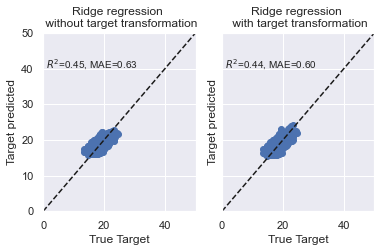

In [111]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

ax0.scatter(y_train, y_pred)
ax0.plot([0, 50], [0, 50], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax0.set_xlim([0, 50])
ax0.set_ylim([0, 50])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_train)

ax1.scatter(y_train, y_pred)
ax1.plot([0, 50], [0, 50], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [112]:
y_pred = pd.DataFrame(y_pred, columns = ['predicted_log'],index=y_train.index)

In [113]:
y_pred.head(2)

,predicted_log
11938,18.114
790,18.735


In [114]:
y_pred1 = train[['assessed_value']]

In [115]:
y_pred1.head(2)

,assessed_value
11938,268557.000
790,95849.000


In [116]:
df1 = pd.concat([y_pred, y_pred1], axis=1)

In [117]:
df1.head(2)

,predicted_log,assessed_value
11938,18.114,268557.000
790,18.735,95849.000


In [118]:
df1['predicted1'] = 2**df1.predicted_log

In [119]:
df1.head(2)

,predicted_log,assessed_value,predicted1
11938,18.114,268557.000,283794.223
790,18.735,95849.000,436415.059


In [120]:
df1.apply(lambda col: median_absolute_error(df1.assessed_value, col))

predicted_log    389591.590
assessed_value        0.000
predicted1       151934.950
dtype: float64

In [121]:
df1.apply(lambda col: r2_score(df1.assessed_value, col))

predicted_log    -0.573
assessed_value    1.000
predicted1        0.393
dtype: float64

# Ridge Regression Summary:
# Median Absolute Error: 159,076
# R2 value: 0.316

----------------------------------------

# Lets now try to remove outliers and then do modeling

In [ ]:
df.head(2)

In [ ]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [ ]:
train = train[train.assessed_value< 1000000]

In [ ]:
#train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [ ]:
#explore.plot_variable_pairs(train_plot)

In [ ]:
#bath_cutoff = train.bathrooms.mean() + 3*train.bathrooms.std()

In [ ]:
#bed_cutoff = train.bedrooms.mean() + 3*train.bedrooms.std()

In [ ]:
#sf_cutoff = train.square_feet.mean() + 3*train.square_feet.std()

In [ ]:
#bath_cutoff, bed_cutoff , sf_cutoff

In [ ]:
#train = train[train.bathrooms<bath_cutoff][train.bedrooms<bed_cutoff][train.square_feet<sf_cutoff]

In [ ]:
#train.assessed_value.max()

In [ ]:
#outliers = train[train.assessed_value>1000000]

In [ ]:
#outliers.info()

In [ ]:
#outliers_plot = outliers[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [ ]:
#explore.plot_variable_pairs(outliers_plot)

In [ ]:
X_train = train[['bedrooms', 'bathrooms', 'log2sf']]
y_train = train[['log2value']]
X_test = test[['bedrooms', 'bathrooms', 'log2sf']]
y_test = test[['log2value']]

In [ ]:
predictions = pd.DataFrame({
    'actual_log': y_train.log2value
})
predictions.head(2)

In [ ]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ bedrooms + bathrooms + log2sf', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols_log'] = ols_model.predict(X_train)

In [ ]:
predictions['actual'] = 2**predictions.actual_log
predictions['ols_predicted'] = 2**predictions.ols_log

In [ ]:
(2**y_train.log2value).mean()

In [ ]:
predictions.head()

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

In [ ]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

In [ ]:
ols_model.summary()

In [ ]:
predictions2 = pd.DataFrame({
    'actual_log': y_test.log2value
})
predictions2.head(2)

In [ ]:
predictions2['test_ols_log'] = ols_model.predict(X_test)

In [ ]:
predictions2['actual'] = 2**predictions2.actual_log
predictions2['test_ols_predicted'] = 2**predictions2.test_ols_log

In [ ]:
predictions2.head(2)

In [ ]:
predictions2.apply(lambda col: median_absolute_error(predictions2.actual, col))

# It is wierd that removing outliers led to higher Median Absolute Error(MAE) on OLS model. However, the MAE is better on test model. 

Lets built a GLM and and then input that in Gamma GAM

In [ ]:
df.head(2)

In [ ]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [ ]:
X_train = train[['square_feet', 'zip_median']]
y_train = train[['log2value']]

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X_train, y_train)

In [ ]:
X_train['predicted_log_value'] = lm.predict(X_train)

In [ ]:
X_train

In [ ]:
X_train['longitude'] = train['longitude']
X_train['latitude'] = train['latitude']

In [ ]:
X_train.head(2)

In [ ]:
X_train = X_train.drop(columns=['square_feet', 'zip_median'])

In [ ]:
X_train.head(2)

In [ ]:
X_train= X_train.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
X_train[0]

In [ ]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(terms = te(1,2) + isintercept.(predicted_log_value))

In [ ]:
gam.gridsearch(X_train, y_train)

In [ ]:
gam.summary()

In [ ]:
y_pred = gam.predict(X_train)
y_pred = pd.DataFrame(y_pred)

In [ ]:
y_pred['actual'] = y_train

In [ ]:
y_pred

In [ ]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [ ]:
f, (ax1) = plt.subplots(1, 1)

ax1.scatter(y_pred['actual1'], y_pred['predicted1'])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_pred['actual1'], y_pred['predicted1']), median_absolute_error(y_pred['actual1'], y_pred['predicted1'])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

#f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [ ]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual1, col))

In [ ]:
y_pred.apply(lambda col: r2_score(y_pred.actual1, col))

In [ ]:
evaluate.plot_residuals(y_pred.actual1, y_pred['predicted1'], y_pred)

-----------GAM simulations-------

In [341]:
X_train = train[['bathrooms', 'square_feet', 'zip_median']]
y_train = train[['assessed_value']]
X_test = test[['bathrooms', 'square_feet', 'zip_median', 'latitude', 'longitude']]
y_test = test[['assessed_value']]
X_test1 = df[['bathrooms', 'square_feet', 'zip_median','latitude', 'longitude']]
y_test1 = df[['assessed_value']]

In [342]:
X_test1 = X_test1.to_numpy()
y_test1 = y_test1.to_numpy()

In [343]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2)+te(3,4))

In [344]:
gam.gridsearch(X_test1,y_test1)

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + te(3, 4) + intercept, tol=0.0001, 
   verbose=False)

In [345]:
y_pred = gam.predict(X_test1)

In [346]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('GAM-spatial.csv')

In [347]:
y_pred['actual'] = y_test1

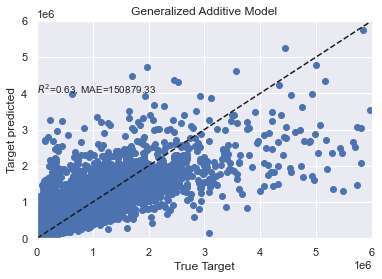

In [348]:
f, (ax1) = plt.subplots(1, 1)


ax1.scatter(y_pred['actual'], y_pred[0])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_pred['actual'], y_pred[0]), median_absolute_error(y_pred['actual'], y_pred[0])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

#f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [349]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

0        150879.335
actual        0.000
dtype: float64

In [350]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

0        0.631
actual   1.000
dtype: float64